## Dataset Description:

The dataset contains 1000 entries with 10 independent variables (4 numerical, 6 categorical). In this dataset, each entry represents a person who takes a credit by a bank.The selected attributes are:

Age (numeric)
Sex (text: male, female)
Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
Housing (text: own, rent, or free)
Saving accounts (text - little, moderate, quite rich, rich)
Checking account (numeric, in DM - Deutsch Mark)
Credit amount (numeric, in DM)
Duration (numeric, in month)
Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

## Customer-Segmentation-using-K-Means-Clustering---German-Credit-Risk

In [1]:
#Imports
import opendatasets as od
import os

import pandas as pd #To work with dataset
import numpy as np #Math library
import plotly.express as px #For Visulization
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from sklearn.pipeline import make_pipeline  #machine learning library
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')
cmap=sns.color_palette('Blues_r')

In [2]:
dataset = "https://www.kaggle.com/datasets/uciml/german-credit"
data = od.download(dataset)

Skipping, found downloaded files in ".\german-credit" (use force=True to force download)


In [3]:
data_dir = ".\german-credit"

In [4]:
os.listdir(data_dir)

['.ipynb_checkpoints']

Reading the raw data

In [5]:
df = pd.read_csv('german_credit_data.csv')
df

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0             0   67    male    2     own             NaN           little   
1             1   22  female    2     own          little         moderate   
2             2   49    male    1     own          little              NaN   
3             3   45    male    2    free          little           little   
4             4   53    male    2    free          little           little   
..          ...  ...     ...  ...     ...             ...              ...   
995         995   31  female    1     own          little              NaN   
996         996   40    male    3     own          little           little   
997         997   38    male    2     own          little              NaN   
998         998   23    male    2    free          little           little   
999         999   27    male    2     own        moderate         moderate   

     Credit amount  Duration              Purpose  
0             1169         6             radio/TV  
1             5951        48             radio/TV  
2             2096        12            education  
3             7882        42  furniture/equipment  
4             4870        24                  car  
..             ...       ...                  ...  
995           1736        12  furniture/equipment  
996           3857        30                  car  
997            804        12             radio/TV  
998           1845        45             radio/TV  
999           4576        45                  car  

[1000 rows x 10 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


In [7]:
df.describe()

Unnamed: 0          Age          Job  Credit amount     Duration
count  1000.000000  1000.000000  1000.000000    1000.000000  1000.000000
mean    499.500000    35.546000     1.904000    3271.258000    20.903000
std     288.819436    11.375469     0.653614    2822.736876    12.058814
min       0.000000    19.000000     0.000000     250.000000     4.000000
25%     249.750000    27.000000     2.000000    1365.500000    12.000000
50%     499.500000    33.000000     2.000000    2319.500000    18.000000
75%     749.250000    42.000000     2.000000    3972.250000    24.000000
max     999.000000    75.000000     3.000000   18424.000000    72.000000

In [8]:
categorical_features =df.select_dtypes('object')

print(f"Unique values by features\n")

for feature in categorical_features:
    unique_values = df[feature].unique()
    print(f"{feature}:\n {unique_values}\n")

Unique values by features

Sex:
 ['male' 'female']

Housing:
 ['own' 'free' 'rent']

Saving accounts:
 [nan 'little' 'quite rich' 'rich' 'moderate']

Checking account:
 ['little' 'moderate' nan 'rich']

Purpose:
 ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']



In [9]:
for col in df.select_dtypes(include=[object]):
    value_count = df[col].value_counts()
    print(f"{col}:\n{value_count}\n")

Sex:
male      690
female    310
Name: Sex, dtype: int64

Housing:
own     713
rent    179
free    108
Name: Housing, dtype: int64

Saving accounts:
little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

Checking account:
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

Purpose:
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64



### Deal with missing values

In [10]:
print("Missing values in each column:", df.isnull().sum())

Missing values in each column: Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64


It looks that the first column is simply an index which we can delete.

In [11]:
df.drop(columns=["Unnamed: 0"], inplace = True)

Saving accounts has 183 missing values and Checking account 394 misisng values. In Saving Account the majority is little so the easist solusion is aasign all the missing value as "little".

For Checking account suggestion: among the many fill misiing value methods, one of them may suitable for this situation. that is create a new catergory value like NoInfo it self is valualbe since the number of missing value is almost the same quntity with any other two most couurences. 274 for littel and 194 missing values.

In [12]:
df['Saving accounts'].fillna('little', inplace = True)
df['Checking account'].fillna('no_info', inplace=True)

## Exploratory Data Analysis

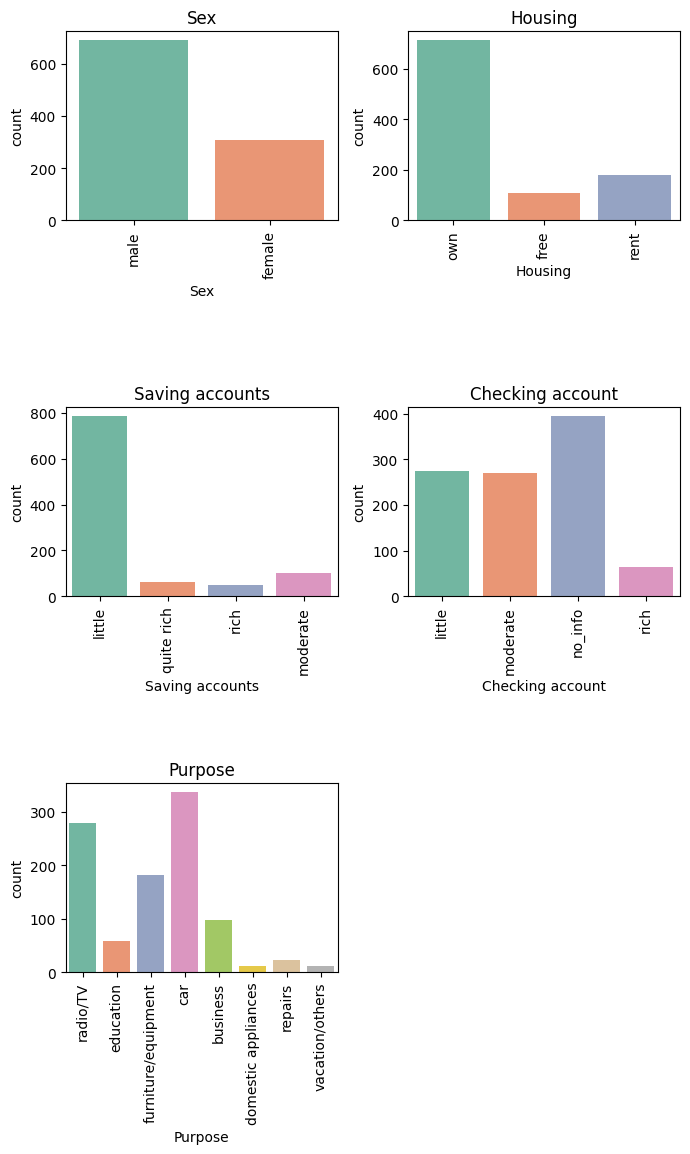

In [13]:
object_features = df.select_dtypes("object", "category")
n = 1

plt.figure(figsize = (7,40))

for feature in object_features:
    
    plt.subplot(11,2,n)
    sns.countplot(x= df[feature], data = df, palette='Set2')
    plt.ylabel('count')
    plt.xticks(rotation = 90)
    plt.title(f'{feature}')
    n = n + 1
    plt.tight_layout()

Among the all catagorical attributes, The value are distributed Unevenly in which most are Skewed to the left. Which may affact the prediction later.

### Numerical Variable Analysis

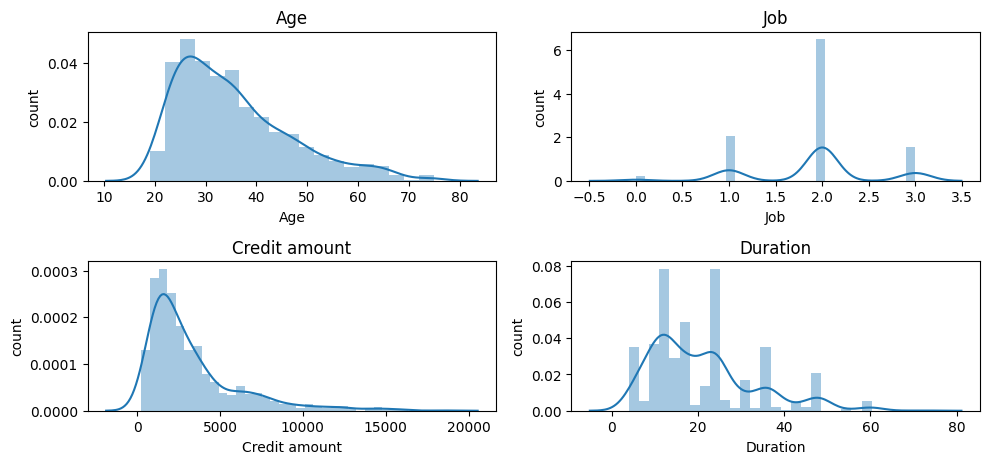

In [14]:
numeric_features = df.select_dtypes('number')
n = 1

plt.figure(figsize = (10, 25))

for feature in numeric_features:
    
    plt.subplot(11,2,n)
    sns.distplot(df[feature])
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.title(f'{feature}')
    n = n + 1
    plt.tight_layout()

####  Among The all two values Age and Credit amount are distributed Unevenly and also are Skewed to the left. Which may affact the prediction later.

## Distribution of ages who take credit at the bank

Text(0.5, 0, 'Age')

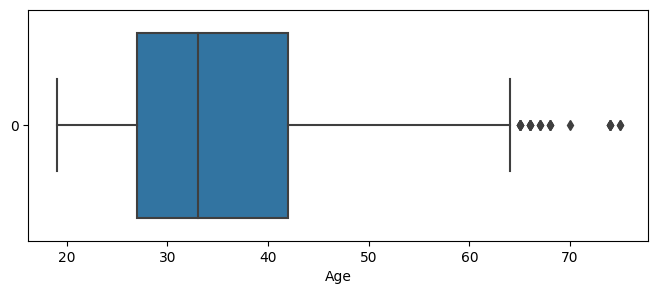

In [15]:
plt.figure(figsize = (8, 3))
sns.boxplot(df['Age'], orient='h')
plt.xlabel('Age')

#### * From the above age plots, insights can be drawn that most of those who take credit at the bank are people between the ages of 27 - 42 years. maybe this is a person who just got married and needs a loan from the bank.
#### * Very few under the age of 20 take credit because it is possible that they are still young and financially they are still supported by their parents.
#### * Meanwhile, relatively few people over 50 years of age take credit, perhaps because people are already established at this age.

## Distribution of the loan amount

Text(0.5, 0, 'Credit amount')

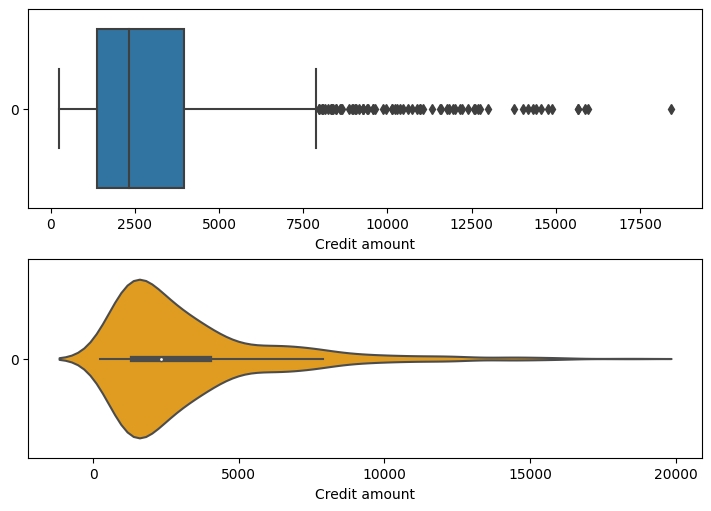

In [16]:
ax = plt.figure(figsize=(7,5), constrained_layout = True)

ax.add_subplot(2,1,1)
sns.boxplot(df['Credit amount'], orient='h')
plt.xlabel('Credit amount')

ax.add_subplot(2,1,2)
sns.violinplot(df['Credit amount'], orient='h', color='Orange')
plt.xlabel('Credit amount')

#### From the boxplot it can be seen that there are a lot of outlier data.
#### From the two plots it can be seen that most people borrow money from banks with a value between 2000 - 3800 US dollars

In [17]:
def countplot(data, h=None, pal=None):
    fig, (ax1, ax2) = plt.subplots(2,2, figsize=(8,6),constrained_layout = True)
    sns.countplot(x="Saving accounts",data = data, hue=h, palette=pal,ax=ax1[0])
    sns.countplot(x="Checking account",data = data, hue=h, palette=pal,ax=ax1[1])
    sns.countplot(x="Job",data = data, hue=h, palette=pal, ax=ax2[0])
    sns.countplot(x="Purpose",data = data, hue=h, palette=pal, ax=ax2[1])
    plt.xticks(rotation = 90)
    plt.tight_layout()

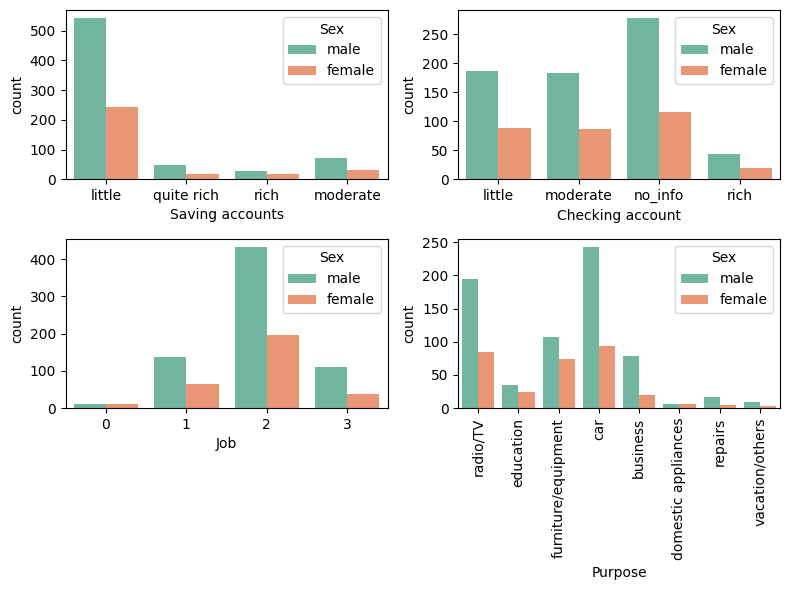

In [18]:
countplot(df, h ="Sex", pal ='Set2' )

From the all above plot can see that male counts are more than beacuse in the data male ratio are more than female.
From the purpose plot can see most of credits were granted for car and radio/TV.

Let's find the correlation between credit amount and duration:

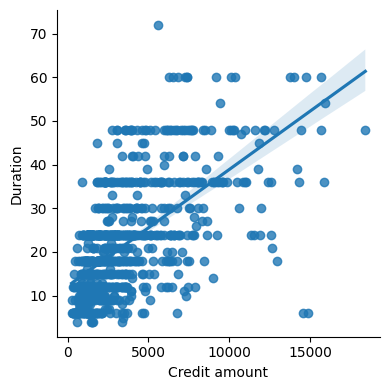

In [19]:
sns.lmplot(x="Credit amount",y="Duration", data=df, height = 4)

The plot above shows a linear correlation which means people take bigger credits for longer periods.

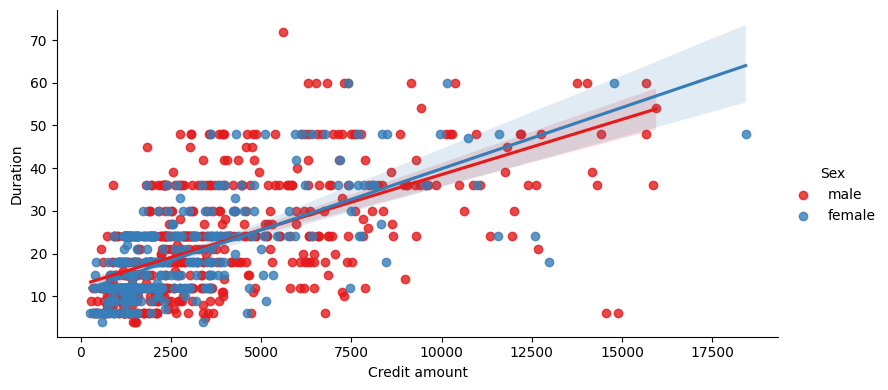

In [20]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=df, palette="Set1", height = 4, aspect=2)

The plot above indicates that there is no significant difference between men and women.

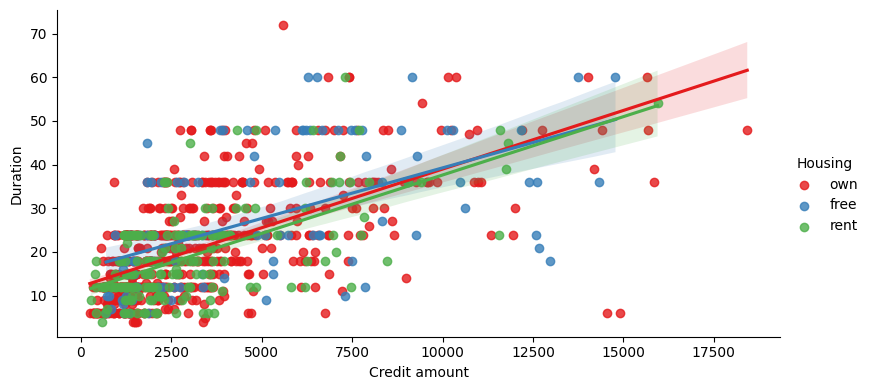

In [21]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=df, palette="Set1",height = 4, aspect=2)

Here from the above plot can see that there is no diference betwen housing categories.

In [22]:
def boxplot(x, y, hue, ro):
    fig, ax = plt.subplots(figsize=(8,5))
    bplot = sns.boxplot(x=x, y=y, hue=hue, data=df)
    bplot.set_xticklabels(bplot.get_xticklabels(), rotation=ro)
    plt.tight_layout()

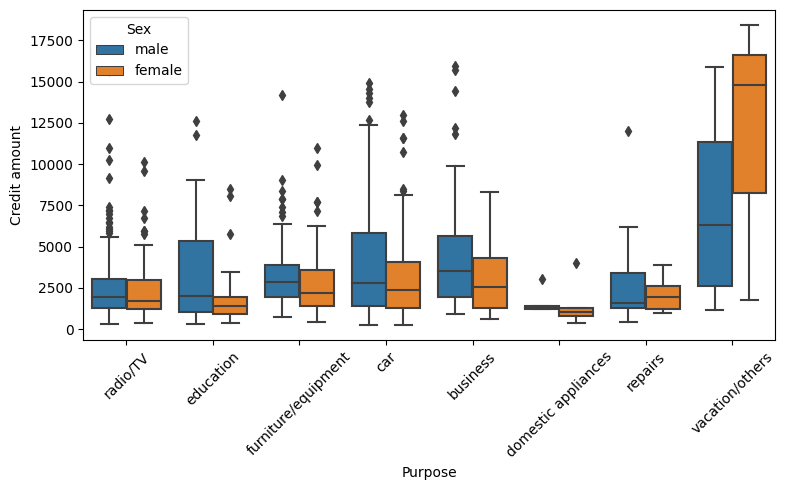

In [23]:
boxplot("Purpose","Credit amount","Sex", ro= 45)

From the above we can see that the biggest amounts are taken for vacations/others and the smallest for domestic appliances. Most of them have outliers(higher amounts) also there is no difference between men and women in the most of cases, despite category vacation/others.

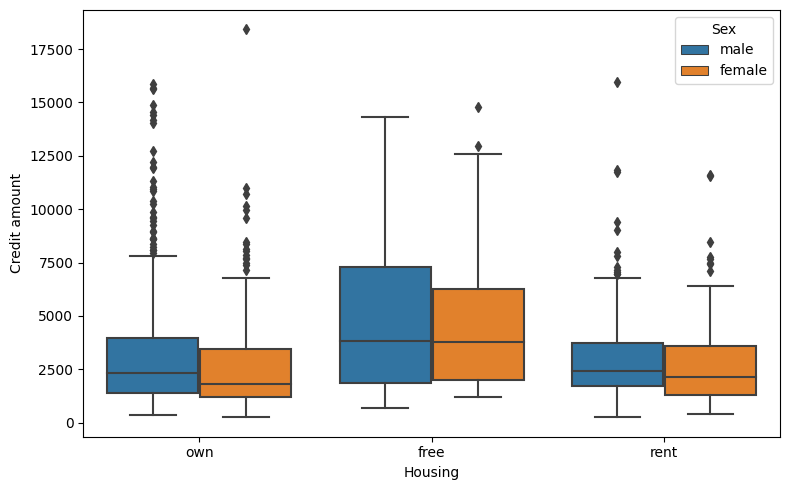

In [24]:
boxplot("Housing","Credit amount","Sex", ro = 0)

In housing category, we can see there is no big difference despite people having “free” housing tend to take slightly bigger credit amounts.

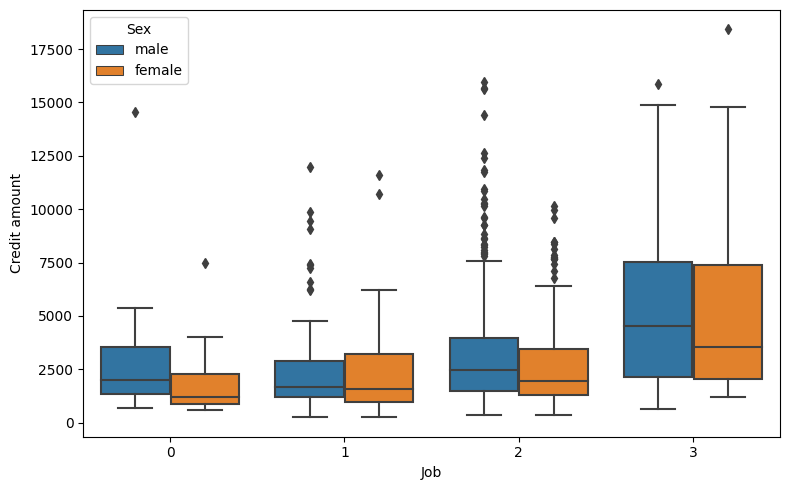

In [25]:
boxplot("Job","Credit amount","Sex", ro=0)

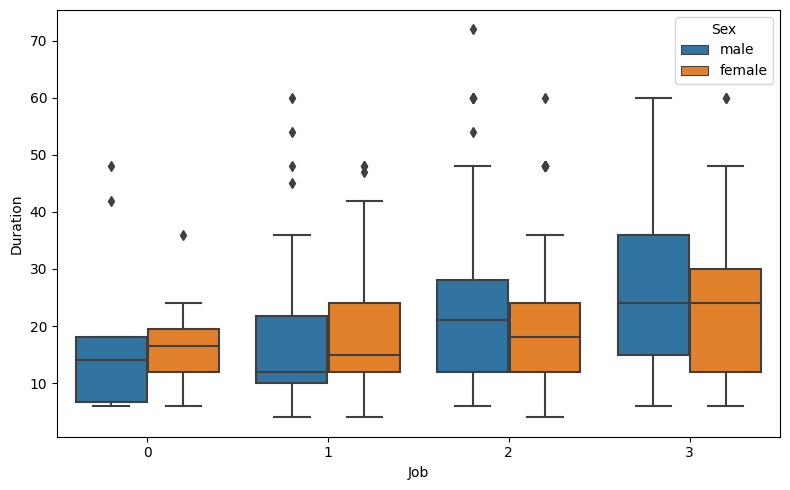

In [26]:
boxplot("Job","Duration","Sex",ro=0)

From above two job plot we can see that there is no bigger diffirence between male and female. Also can see that  job category 3 tends to take bigger credit amounts for longer duration.

## Clustering with KMeans

In [27]:
#Selecting columns for clusterisation with k-means
cols = ["Age","Credit amount", "Duration"]
X= df[cols]

From Numerical Variable Analysis we have seen that Age, Duration and Credit amount are distributed Unevenly and are Skewed to the left  Which may affact the prediction later. To obtain better results We need to normalise them by performming a log transformation before using these features in our modelling. After that let's see how they look like.

In [28]:
# Log transform function
def log_transform(data, to_log):
    X = data.copy()
    for item in to_log:
        # Add 1 to the data to prevent infinity values
        X[item] = np.log(1+X[item])
    return X

In [29]:
# log transfer
df = log_transform(df, ['Age', 'Credit amount', 'Duration'])

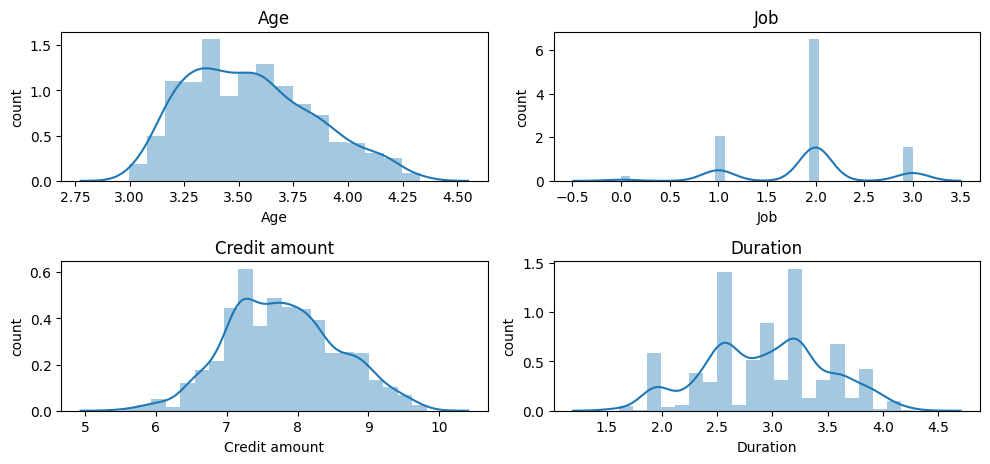

In [30]:
# check the result
numeric_features = df.select_dtypes('number')
n = 1

plt.figure(figsize = (10, 25))

for feature in numeric_features:
    
    plt.subplot(11,2,n)
    sns.distplot(df[feature])
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.title(f'{feature}')
    n = n + 1
    plt.tight_layout()

The skewness has been eliminated.

## Building The K Means model

The next step will be develope the K Means model for that we need use StandardScaler for centering and scaling of variables.

In [31]:
n_clusters = range(2,13)
inertia_errors = []
silhouette_scores = []

#Add for loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    #Building Model
    model= make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    #Train model
    model.fit(X)
    #Calculate Inertia
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    # Calculate Silhouette score
    silhouette_scores.append(silhouette_score(X, model.named_steps['kmeans'].labels_)
    )

print("Inertia:", inertia_errors[:11])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [1884.956793612374, 1297.432037382308, 1066.4953986771034, 943.4531977224742, 834.7089758057227, 749.8204025984702, 689.9202656365819, 635.536005107487, 594.7698584343773, 550.9296617153677, 518.5075365907637]

Silhouette Scores: [0.5942668767661433, 0.09171075408788067, 0.07596137539363931]


In [32]:
#create line plot of 'Inertia' vs 'n_clusters'.

fig = px.line(
    x=n_clusters,
    y=inertia_errors,
    title = "K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title= 'Number of cluster(k)', yaxis_title='Inertia')
fig.show()

Above plot shows that inertia decreases with increasing number of clusters.
The "elbow" in above chart is indicated at 3 & 4 which can be further finalise from the 'Silhouette Scores' vs 'n_clusters'.

In [33]:
#create line plot of 'Silhouette Scores' vs 'n_clusters'.

fig = px.line(
    x=n_clusters,
    y=silhouette_scores,
    title = "K-Means Model: Silhouette Scores vs Number of Clusters"
)
fig.update_layout(xaxis_title= 'Number of cluster(k)', yaxis_title='Silhouette Scores')
fig.show()

The best score for the Silhouette Scores is 1 or near to 1. Above plot shows that for number of cluster 3 has more Silhouette Scores than the no. of cluster 4.

So I will choose final number of cluster=3 for the final model.

In [34]:
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=3, random_state=42)
)

final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [35]:
#Create dataframe that contains the mean values of the features in X for the 3 clusters in final_model.

labels = final_model.named_steps['kmeans'].labels_
XGB = X.groupby(labels).mean().round(1)
XGB

Age  Credit amount  Duration
0  29.7         2205.5      16.9
1  51.7         2398.5      15.8
2  34.7         7587.2      39.3

Cluster 0 - lower mean of credit amount, short duration, young customers

Cluster 1 - lower mean of credit amount, short duration, older customers

Cluster 2 - high mean of credit amount, long duration, middle-aged customers

In [36]:
df_labels = pd.DataFrame(labels)
X = X.assign(Cluster=df_labels)

In [37]:
def scatters(data, h=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,6))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette='Set2', data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette='Set2', data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette='Set2', data=data, ax=ax3)
    plt.tight_layout()

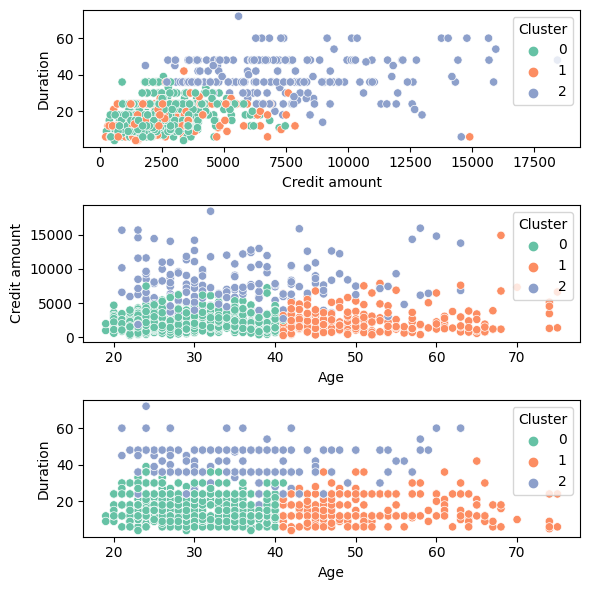

In [38]:
scatters(X, 'Cluster' )

# Exploratory Data Analysis (EDA) Conclusion:

* Men take more credit than women.
* Most of those who borrow credit are those whose jobs are of the skilled type and those who already own a home.
* from above second observation can say that bank only give credit to residents whose jobs are skilled and who own a house may be because the bank believes they will be able to return the loan money. 
* Most people borrow money from banks with a value between 2000 - 3800 US dollars.
* Most people choose to pay off credit with terms of 24 months and 12 months.
* The average person borrows credit to meet tertiary needs such as buying a car/radio and television.
* Most of Men borrows credit for buying car.
* That most people who borrow from banks have a small savings and checking account.
* There is a positive but not too strong correlation between the job with the duration of the loan and the job with the number of loans borrowed. so when the job value increases or the person becomes more skilled, he or she dares to borrow more credit.
* for the correlation between duration and credit amount is a strong positive. where by increasing the duration of credit repayments, people will be more daring to borrow larger loans.
* Many people borrow credit for vacations, the average number of credits for vacations is the largest. So it's possible that everyone is willing to borrow more credit for a vacation.

# Conclusion From Customer Segmentation:

* Cluster 0 - lower mean of credit amount, short duration, young customers
* Cluster 1 - lower mean of credit amount, short duration, older customers
* Cluster 2 - high mean of credit amount, long duration, middle-aged customers.

From above Three cluster can say that the young  customer who is under 28 mean age has borrow lower credit for short duration beacuse it may possible that they are still young and financially they are still supported by their parents.
middle-aged customers have taken credit in higher amount for longer duration. 